# Import Library

In [49]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
%matplotlib inline
from datetime import datetime as dt
from collections import defaultdict
import lightgbm as lgb


from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.24.3
pandas version :  1.5.3
seaborn version :  0.12.2


# Basic Understanding of The Data

In [50]:
df = pd.read_csv('Clicked Ads Dataset.csv')
df.head()

,Unnamed: 0,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,0,68.95,35,432837300.0,256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,1,80.23,31,479092950.0,193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,2,69.47,26,418501580.0,236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,3,74.15,29,383643260.0,245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,4,68.37,35,517229930.0,225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1000 non-null   int64  
 1   Daily Time Spent on Site  987 non-null    float64
 2   Age                       1000 non-null   int64  
 3   Area Income               987 non-null    float64
 4   Daily Internet Usage      989 non-null    float64
 5   Male                      997 non-null    object 
 6   Timestamp                 1000 non-null   object 
 7   Clicked on Ad             1000 non-null   object 
 8   city                      1000 non-null   object 
 9   province                  1000 non-null   object 
 10  category                  1000 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 86.1+ KB


In [52]:
df.shape

(1000, 11)

Hasil `df.shape` menunjukkan bahwa DataFrame `df` memiliki 1000 baris dan 11 kolom. Ini berarti DataFrame tersebut terdiri dari 1000 data (baris) dan 11 fitur (kolom).

## Data Exploration

In [53]:
nums = []
cats = []

for col in df:
    if df[col].dtypes in ['int64','float64']:
        nums.append(col)
    else:
        cats.append(col)
        
nums_count = len(nums)
cats_count = len(cats)

print('Number of numerical columns:', nums_count)
print('Number of categorical columns:', cats_count)
print('-' * 70)
print('Numerical columns:', nums)
print('Categorical columns:', cats)

Number of numerical columns: 5
Number of categorical columns: 6
----------------------------------------------------------------------
Numerical columns: ['Unnamed: 0', 'Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
Categorical columns: ['Male', 'Timestamp', 'Clicked on Ad', 'city', 'province', 'category']


In [54]:
check_items = []
for col in df.columns:
    check_items.append([col, df[col].dtype, df[col].isna().sum(), 100*df[col].isna().sum()/len(df[col]), df[col].nunique(), df[col].unique()[:5]])
df_desc = pd.DataFrame(data=check_items, columns='Feature,Data Type,Null, Null (%),Unique,Unique Sample'.split(","))
df_desc

,Feature,Data Type,Null,Null (%),Unique,Unique Sample
0,Unnamed: 0,int64,0,0.0,1000,"[0, 1, 2, 3, 4]"
1,Daily Time Spent on Site,float64,13,1.3,890,"[68.95, 80.23, 69.47, 74.15, 68.37]"
2,Age,int64,0,0.0,43,"[35, 31, 26, 29, 23]"
3,Area Income,float64,13,1.3,987,"[432837300.0, 479092950.00000006, 418501580.0,..."
4,Daily Internet Usage,float64,11,1.1,955,"[256.09, 193.77, 236.5, 245.89, 225.58]"
5,Male,object,3,0.3,2,"[Perempuan, Laki-Laki, nan]"
6,Timestamp,object,0,0.0,997,"[3/27/2016 0:53, 4/4/2016 1:39, 3/13/2016 20:3..."
7,Clicked on Ad,object,0,0.0,2,"[No, Yes]"
8,city,object,0,0.0,30,"[Jakarta Timur, Denpasar, Surabaya, Batam, Medan]"
9,province,object,0,0.0,16,"[Daerah Khusus Ibukota Jakarta, Bali, Jawa Tim..."


Berdasarkan hasil tersebut, terdapat beberapa insight yang dapat diperoleh:

1. **Null Values:**
   - **Daily Time Spent on Site, Area Income, Male dan Daily Internet Usage memiliki nilai null.** Dalam hal ini, persentase nilai null cukup kecil (kurang dari 5%), sehingga tidak akan terlalu mempengaruhi hasil analisis secara signifikan.

2. **Data Types:**
   - **Feature Male memiliki tipe data object.** Sebaiknya diubah menjadi tipe data yang sesuai, seperti boolean (0 atau 1) atau kategorikal.
   - **Feature Timestamp** lebih baik menggunakan type data datetime

3. **Unique Values:**
   - **Feature Unnamed: 0 memiliki 1000 nilai unique.** Hal ini menunjukkan bahwa kolom ini mungkin merupakan indeks atau nomor baris yang tidak memberikan informasi yang berguna untuk analisis. Sebaiknya dihapus dari dataset.

4. **Target Feature:**
   - **Feature Clicked on Ad mungkin menjadi target dalam analisis.** menjadi target feature.

# Exploratory Data Analysis

In [55]:
df_eda = df.copy()

## Statistical Analysis

In [56]:
df_eda[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,4.995000e+02,2.888194e+02,0.00,2.497500e+02,4.995000e+02,7.492500e+02,9.990000e+02
Daily Time Spent on Site,987.0,6.492952e+01,1.584470e+01,32.60,5.127000e+01,6.811000e+01,7.846000e+01,9.143000e+01
Age,1000.0,3.600900e+01,8.785562e+00,19.00,2.900000e+01,3.500000e+01,4.200000e+01,6.100000e+01
Area Income,987.0,3.848647e+08,9.407999e+07,97975500.00,3.286330e+08,3.990683e+08,4.583554e+08,5.563936e+08
Daily Internet Usage,989.0,1.798636e+02,4.387014e+01,104.78,1.387100e+02,1.826500e+02,2.187900e+02,2.670100e+02


In [57]:
df_eda[cats].describe().T

,count,unique,top,freq
Male,997,2,Perempuan,518
Timestamp,1000,997,5/26/2016 15:40,2
Clicked on Ad,1000,2,No,500
city,1000,30,Surabaya,64
province,1000,16,Daerah Khusus Ibukota Jakarta,253
category,1000,10,Otomotif,112


### Univariate Analysis

In [58]:
nums = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
cats = ['Male', 'Clicked on Ad', 'city', 'province', 'category']

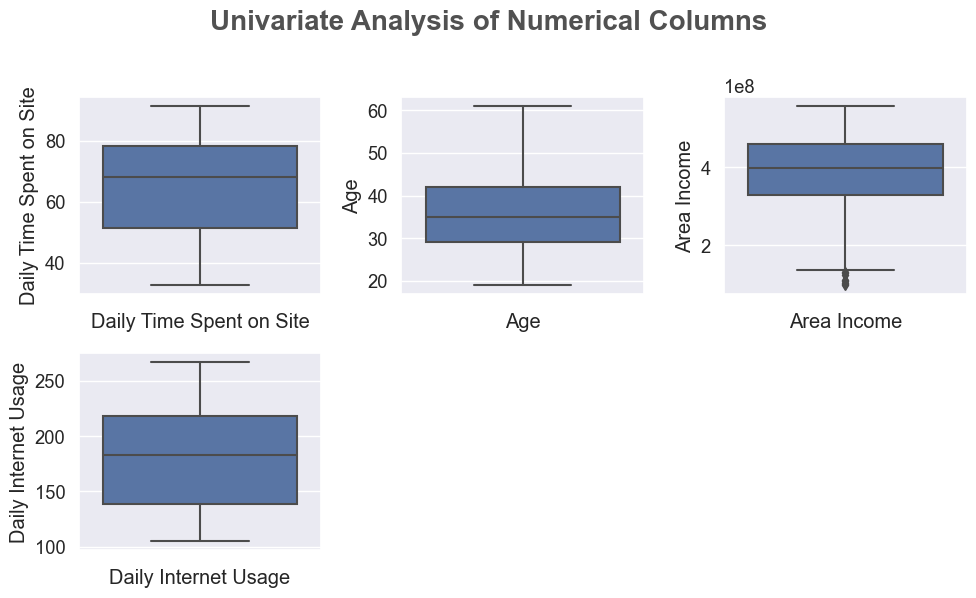

In [59]:
plt.figure(figsize=(10, 6))
plt.suptitle('Univariate Analysis of Numerical Columns', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i, col in enumerate(nums):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df_eda[col])
    plt.xlabel(col)
plt.tight_layout()
plt.show()

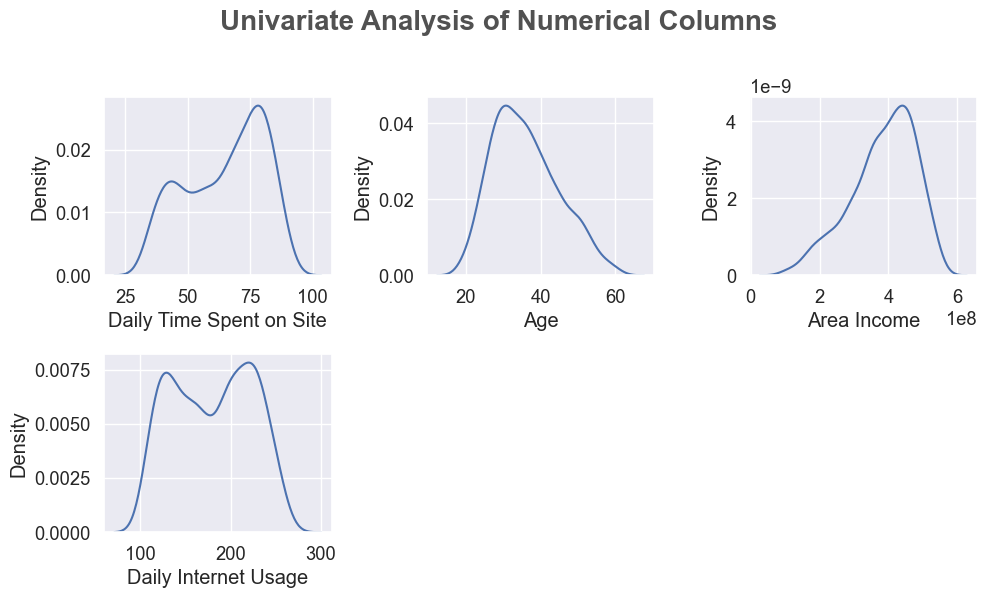

In [60]:
plt.figure(figsize=(10, 6))
plt.suptitle('Univariate Analysis of Numerical Columns', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i, col in enumerate(nums):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(x=df_eda[col])
    plt.xlabel(col)
plt.tight_layout()
plt.show()

- **Daily Time Spent on Site:** Rata-rata waktu yang dihabiskan harian di situs adalah sekitar 64.93 menit, dengan standar deviasi sekitar 15.84 menit. Waktu minimum yang dihabiskan adalah 32.60 menit dan maksimumnya adalah 91.43 menit.
- **Age:** Rata-rata usia responden adalah sekitar 36 tahun, dengan standar deviasi sekitar 8.79 tahun. Usia minimum adalah 19 tahun dan maksimumnya adalah 61 tahun.
- **Area Income:** Rata-rata pendapatan area responden adalah sekitar 384,864,700, dengan standar deviasi sekitar 94,079,990. Pendapatan area minimum adalah 97,975,500 dan maksimumnya adalah 556,393,600.
- **Daily Internet Usage:** Rata-rata penggunaan internet harian adalah sekitar 179.86 MB, dengan standar deviasi sekitar 43.87 MB. Penggunaan internet harian minimum adalah 104.78 MB dan maksimumnya adalah 267.01 MB.

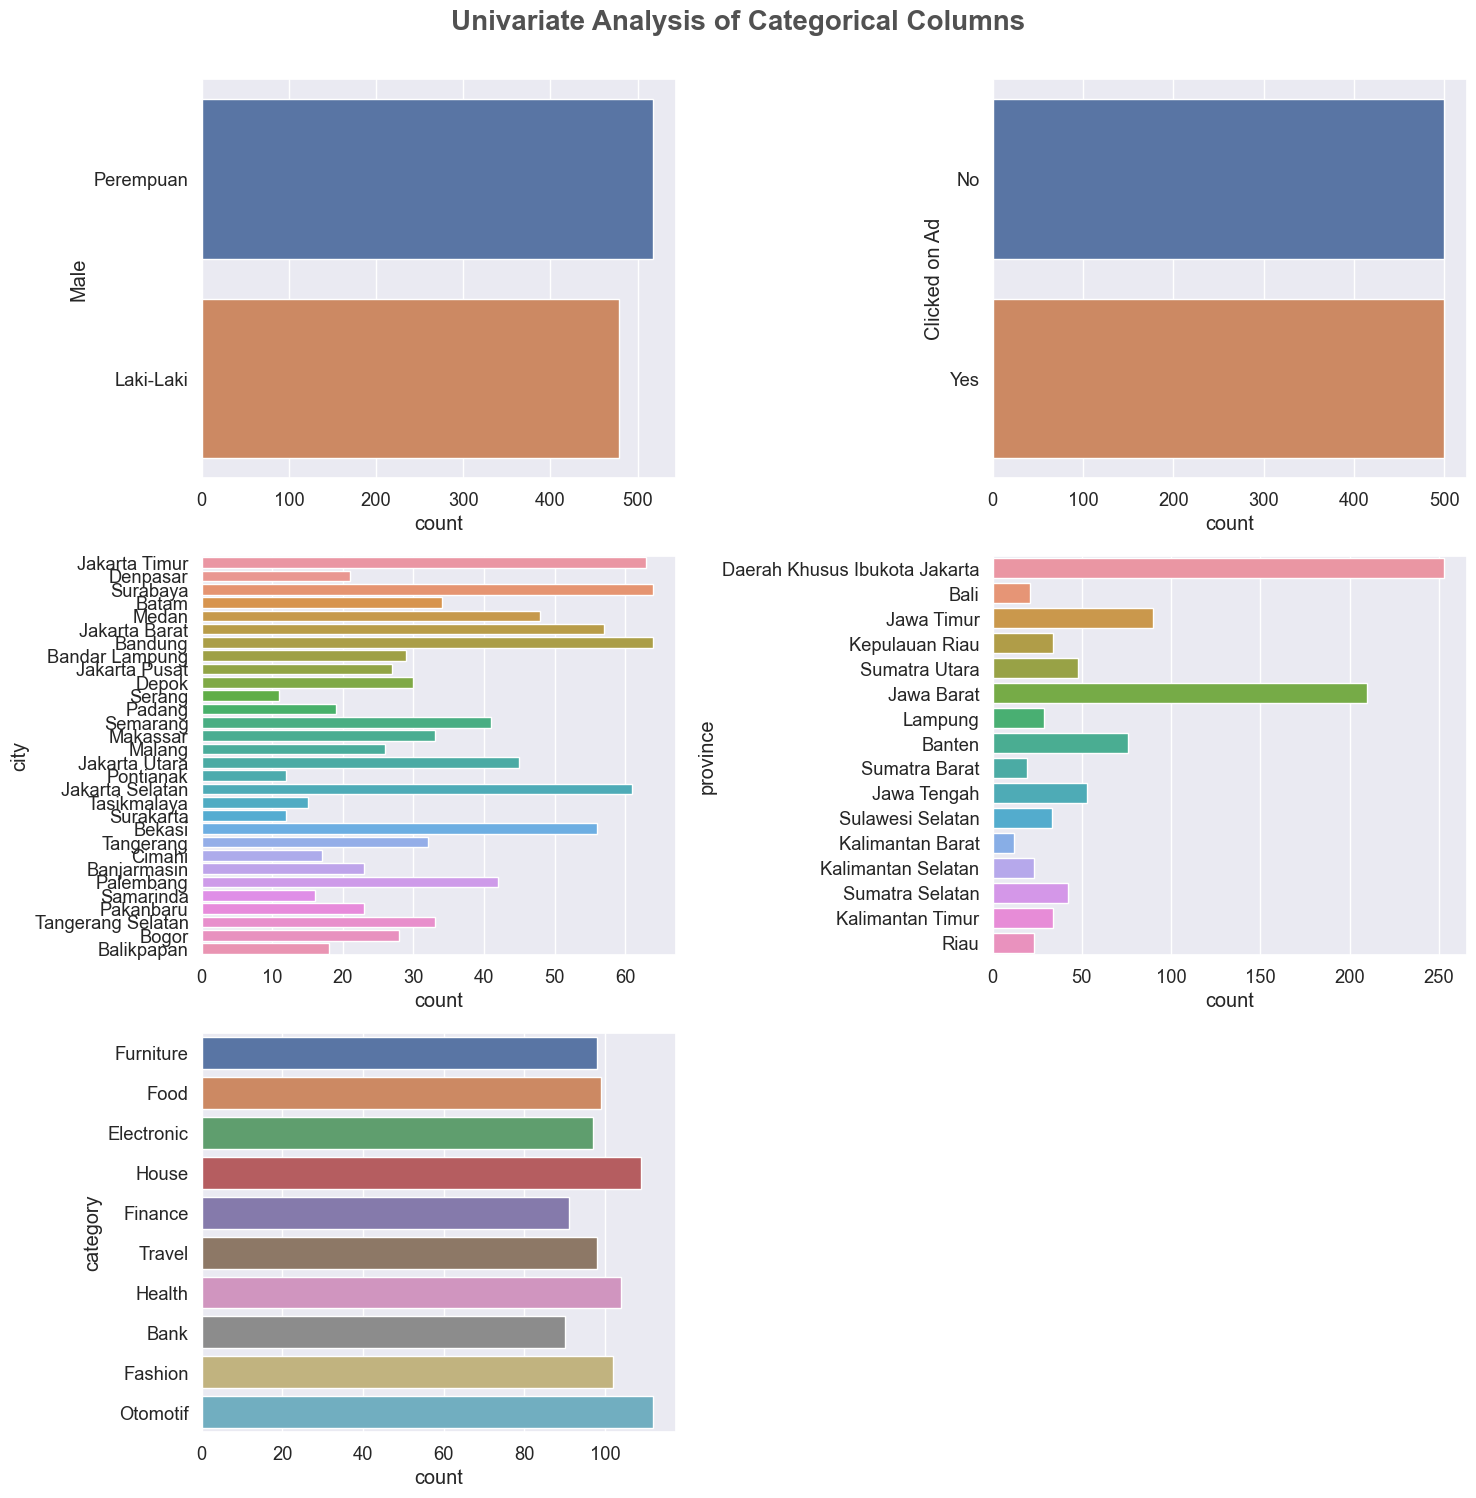

In [61]:
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Categorical Columns', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i in range(0, len(cats)):
    plt.subplot(3,2,i+1)
    sns.countplot(y=df_eda[cats[i]], orient = 'h')
    plt.tight_layout()

plt.tight_layout()
plt.show()

- **Male (Jenis Kelamin):** Terdapat 997 entri dalam kolom ini, dengan 2 nilai unik yaitu "Perempuan" dan "Laki-laki". Nilai yang paling sering muncul (mode) adalah "Perempuan" dengan frekuensi 518.
- **Clicked on Ad (Klik pada Iklan):** Terdapat 1000 entri dalam kolom ini, dengan 2 nilai unik yaitu "Yes" dan "No". Nilai yang paling sering muncul adalah "No" dengan frekuensi 500.
- **City (Kota):** Terdapat 1000 entri dalam kolom ini, dengan 30 nilai unik yang mewakili nama-nama kota. Kota "Surabaya" adalah yang paling sering muncul dengan frekuensi 64.
- **Province (Provinsi):** Terdapat 1000 entri dalam kolom ini, dengan 16 nilai unik yang mewakili nama-nama provinsi. Provinsi "Daerah Khusus Ibukota Jakarta" adalah yang paling sering muncul dengan frekuensi 253.
- **Category (Kategori):** Terdapat 1000 entri dalam kolom ini, dengan 10 nilai unik yang mewakili kategori-kategori tertentu. Kategori "Otomotif" adalah yang paling sering muncul dengan frekuensi 112.

### Bivariate Analysis

In [62]:
target = df_eda.groupby('Clicked on Ad')['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage'].agg(['mean','median'])
target

Daily Time Spent on Site             Age          Area Income  \
                                  mean  median    mean median          mean   
Clicked on Ad                                                                 
No                           76.787805  77.615  31.684   31.0  4.299090e+08   
Yes                          53.143111  51.500  40.334   40.0  3.400933e+08   

                           Daily Internet Usage          
                    median                 mean  median  
Clicked on Ad                                            
No             436334990.0           214.595233  216.50  
Yes            344980090.0           145.342077  138.79

#### Numerical Vs Target

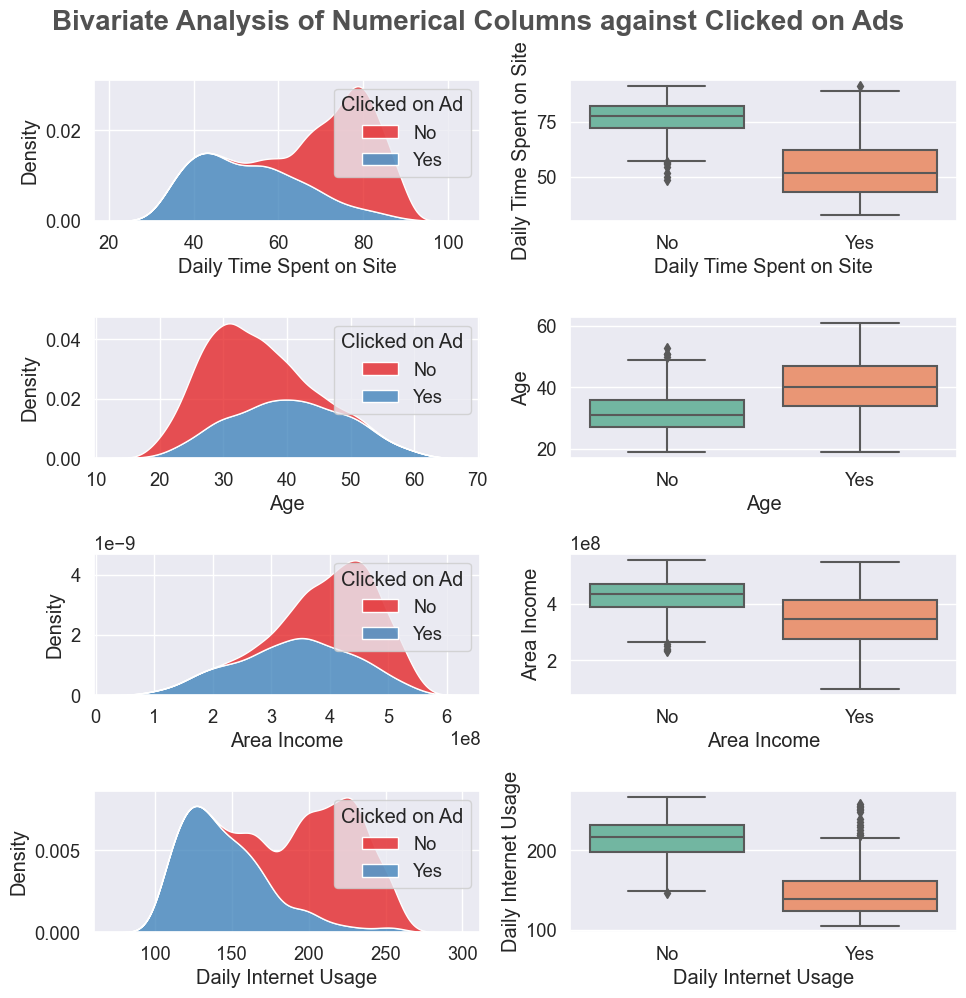

In [63]:
plt.figure(figsize=(10, 10))
plt.suptitle('Bivariate Analysis of Numerical Columns against Clicked on Ads', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

# Plot KDE dan Box plot untuk setiap kolom numerikal dengan target 'ProdTaken'
for i, col in enumerate(nums):
    plt.subplot(4, 2, 2*i+1)
    sns.kdeplot(data=df_eda, x=col, hue='Clicked on Ad', fill=True, multiple='stack', palette='Set1')
    plt.xlabel(col)
    
    plt.subplot(4, 2, 2*i+2)
    sns.boxplot(data=df_eda, x='Clicked on Ad', y=col, palette='Set2')
    plt.xlabel(col)
    
plt.tight_layout()
plt.show()

- Daily Time Spent on Site: Pengguna yang tidak Clicked on Ad memiliki rata-rata waktu yang lebih lama di situs (76.79 menit) dibandingkan dengan pengguna yang Clicked on Ad (53.14 menit). Median waktu yang dihabiskan juga menunjukkan pola yang sama.
- Age: Rata-rata usia pengguna yang tidak Clicked on Ad (31.68 tahun) lebih rendah dibandingkan dengan pengguna yang Clicked on Ad (40.33 tahun). Median usia juga menunjukkan pola yang sama.
- Area Income: Rata-rata dan median Area Income pengguna yang tidak Clicked on Ad lebih tinggi daripada pengguna yang Clicked on Ad. Ini menunjukkan bahwa pengguna dengan pendapatan area yang lebih tinggi cenderung untuk tidak Clicked on Ad.
- Daily Internet Usage: Pengguna yang tidak Clicked on Ad memiliki rata-rata penggunaan internet harian yang lebih tinggi (214.60 MB) dibandingkan dengan pengguna yang Clicked on Ad (145.34 MB). Median penggunaan internet harian juga menunjukkan pola yang sama.

#### Categorical Vs Target

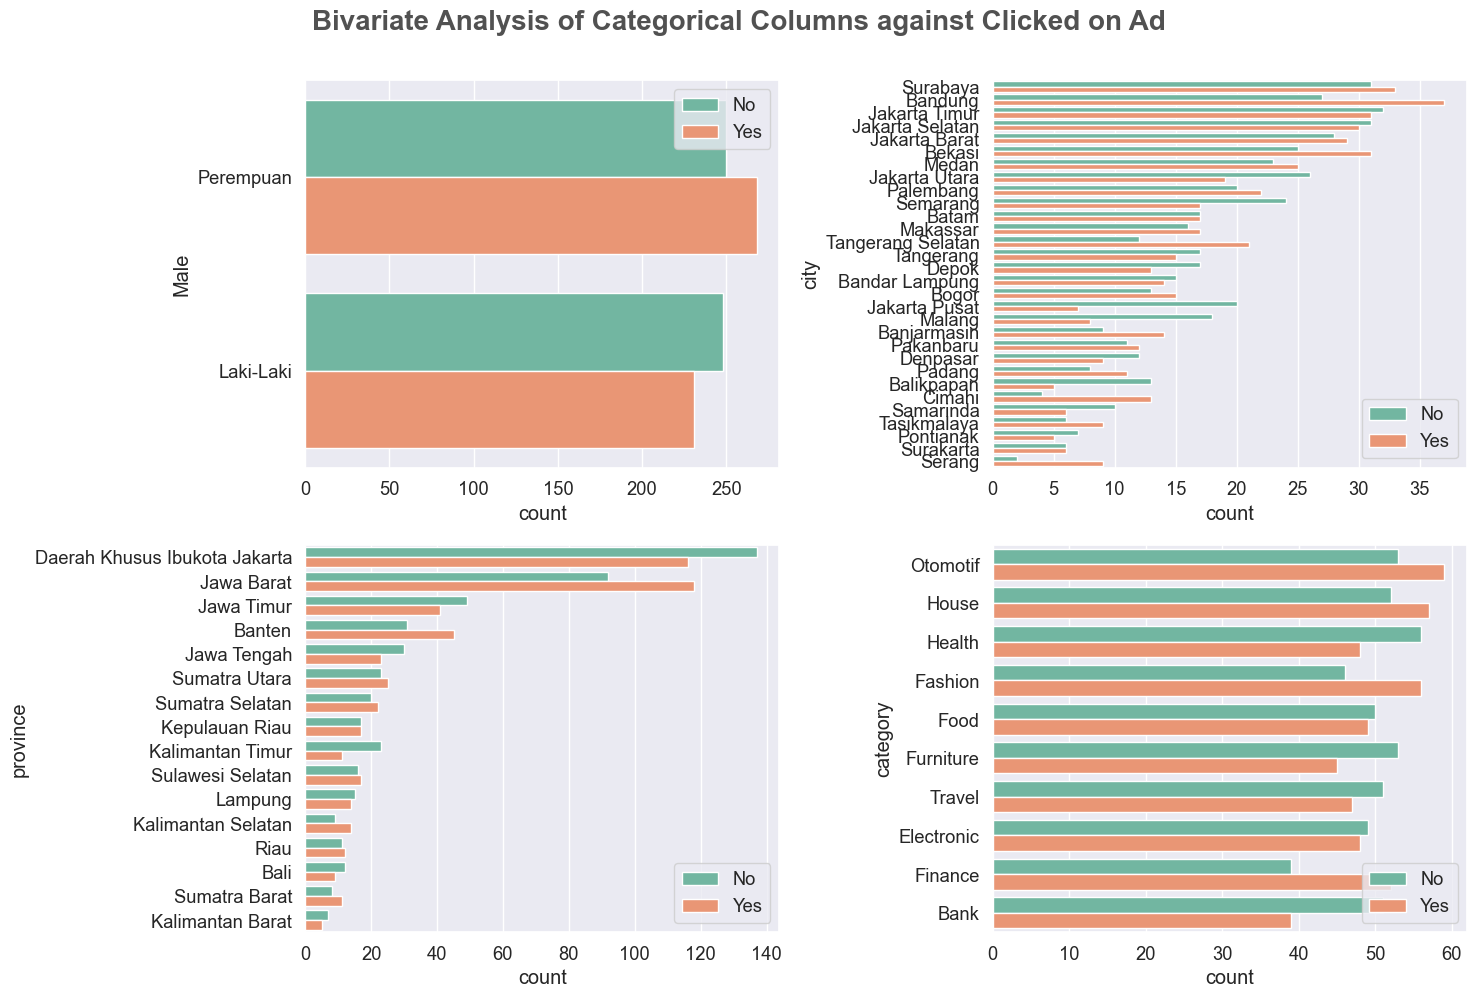

In [64]:
cats = ['Male', 'city', 'province', 'category']

plt.figure(figsize=(15, 10))
plt.suptitle('Bivariate Analysis of Categorical Columns against Clicked on Ad', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(cats)):
    plt.subplot(2, 2, i+1)
    sorted_vals = df_eda[cats[i]].value_counts().index
    ax = sns.countplot(y=df_eda[cats[i]], hue=df_eda['Clicked on Ad'], order=sorted_vals, palette='Set2')
    
    plt.legend(['No', 'Yes'])

plt.tight_layout()
plt.show()


- Lebih banyak pengguna perempuan yang Clicked on Ads dibandingkan pengguna laki-laki pada fitur Male.
- Kota Bandung memiliki jumlah pengguna yang paling banyak Clicked on Ads.
- Pengguna di Provinsi Jawa Barat cenderung untuk Clicked on Ads yang diberikan, sementara pengguna di DKI Jakarta lebih banyak yang menghiraukan iklan.
- Kategori iklan Otomotif cenderung memiliki lebih banyak klik, diikuti oleh Fashion dan House. Sementara kategori Health memiliki jumlah tertinggi untuk tidak Clicked on Ads.

#### Pairplot

<Figure size 1000x1000 with 0 Axes>

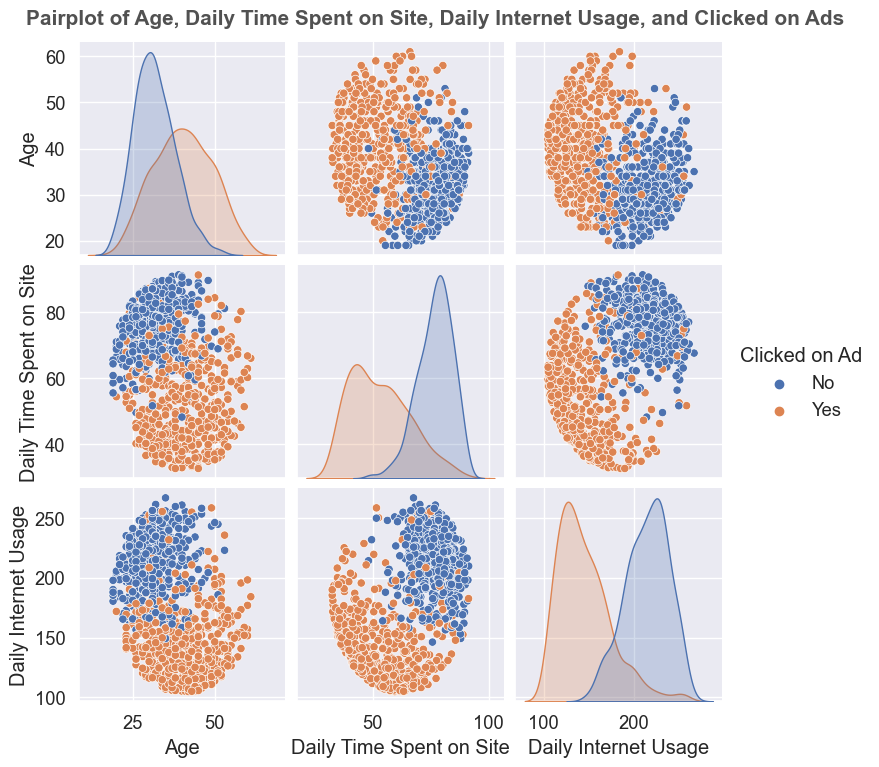

In [65]:
plt.figure(figsize=(10, 10))
sns.pairplot(df_eda[['Age', 'Daily Time Spent on Site', 'Daily Internet Usage', 'Clicked on Ad']], diag_kind='kde', hue='Clicked on Ad')
plt.suptitle('Pairplot of Age, Daily Time Spent on Site, Daily Internet Usage, and Clicked on Ads', fontsize=15, fontweight='bold', alpha=0.8, y=1.02)
plt.show()

### Multivariate Analysis

In [66]:
corr = df_eda.corr()

# Membuat matriks korelasi dalam bentuk kolom
corr_stacked = corr.stack().reset_index()
corr_stacked.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Menampilkan hasil
print(corr_stacked)

                   Feature 1                 Feature 2  Correlation
0                 Unnamed: 0                Unnamed: 0     1.000000
1                 Unnamed: 0  Daily Time Spent on Site    -0.032637
2                 Unnamed: 0                       Age     0.001835
3                 Unnamed: 0               Area Income    -0.056862
4                 Unnamed: 0      Daily Internet Usage    -0.004842
5   Daily Time Spent on Site                Unnamed: 0    -0.032637
6   Daily Time Spent on Site  Daily Time Spent on Site     1.000000
7   Daily Time Spent on Site                       Age    -0.331424
8   Daily Time Spent on Site               Area Income     0.308266
9   Daily Time Spent on Site      Daily Internet Usage     0.518294
10                       Age                Unnamed: 0     0.001835
11                       Age  Daily Time Spent on Site    -0.331424
12                       Age                       Age     1.000000
13                       Age               Area 

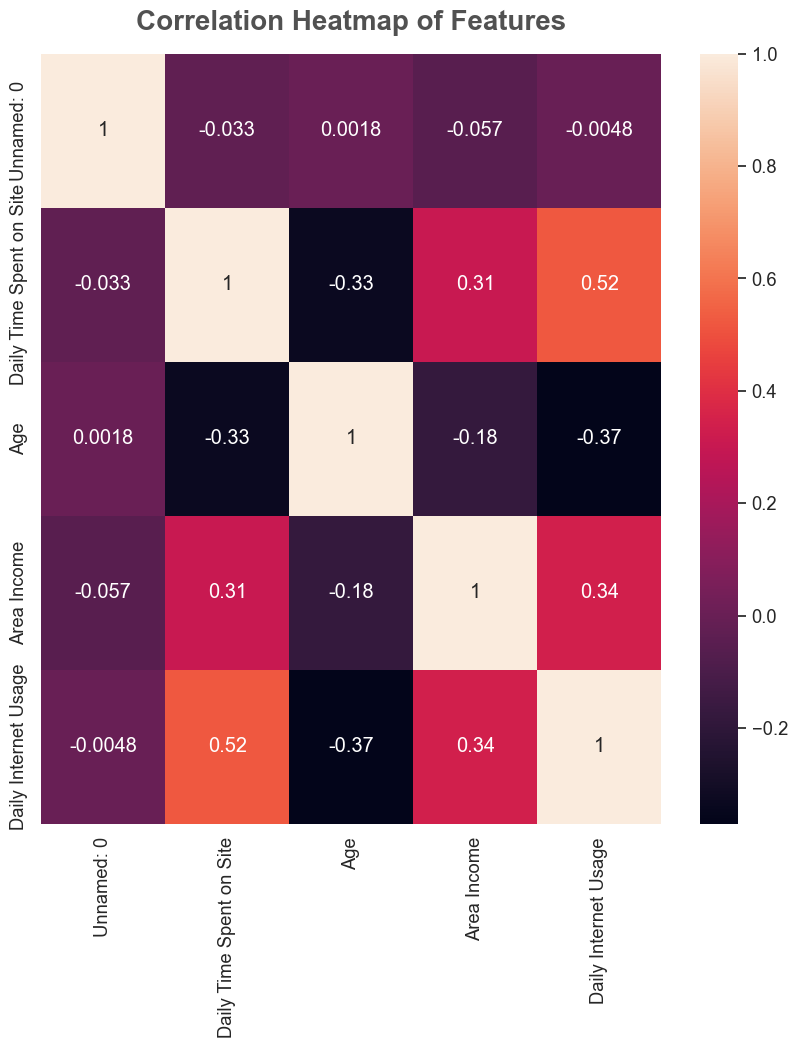

In [67]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_eda.corr(), annot=True, cmap='rocket')
plt.title('Correlation Heatmap of Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.02)
plt.show()

1. **Daily Time Spent on Site dan Daily Internet Usage**: Korelasi positif yang kuat (0.52). Ini berarti semakin lama pengguna menghabiskan waktu di situs, semakin tinggi penggunaan internet harian mereka.

2. **Daily Time Spent on Site dan Area Income**: Korelasi positif yang cukup kuat (0.31). Artinya, orang dengan pendapatan area yang lebih tinggi cenderung menghabiskan lebih banyak waktu di situs.

3. **Age dan Daily Time Spent on Site**: Korelasi negatif yang sedang (-0.33). Ini menunjukkan bahwa semakin tua seseorang, kemungkinan mereka menghabiskan waktu di situs web cenderung lebih sedikit.

4. **Age dan Daily Internet Usage**: Korelasi negatif yang sedang (-0.37). Ini menunjukkan bahwa semakin tua seseorang, penggunaan internet harian mereka cenderung sedikit lebih rendah.

5. **Area Income dan Daily Internet Usage**: Korelasi positif yang cukup kuat (0.34). Orang dengan pendapatan area yang lebih tinggi cenderung memiliki penggunaan internet harian yang lebih tinggi.

# Data Preprocessing

### Handling Missing Value

In [68]:
df_prep = df_eda.copy()

In [69]:
missing_count = df_prep.isnull().sum()

# Menghitung persentase missing value pada setiap kolom
missing_percentage = round((df_prep.isnull().sum() / len(df_prep)) * 100,2)

# Menggabungkan kedua Series ke dalam DataFrame
missing_df = pd.concat([missing_count, missing_percentage], axis=1)
missing_df.columns = ['Jumlah Missing Value', 'Persentase (%)']

# Menampilkan kolom-kolom yang memiliki nilai null beserta persentase missing valuenya
missing_df[missing_df['Jumlah Missing Value'] > 0]

,Jumlah Missing Value,Persentase (%)
Daily Time Spent on Site,13,1.3
Area Income,13,1.3
Daily Internet Usage,11,1.1
Male,3,0.3


In [70]:
# Mencari Nilai Null dengan Whitespace dalam DataFrame 
white_space = []
for col in df_prep.columns:
    for val in df_prep[col]:
        if isinstance(val, str) and '  ' in val:
            white_space.append(val)

# Output
print(white_space)

[]


Daily Time Spent on Site: Terdapat 13 nilai yang hilang, yang setara dengan sekitar 1.3% dari total data pada kolom ini.
Area Income: Terdapat 13 nilai yang hilang, yang setara dengan sekitar 1.3% dari total data pada kolom ini.
Daily Internet Usage: Terdapat 11 nilai yang hilang, yang setara dengan sekitar 1.1% dari total data pada kolom ini.
Male: Terdapat 3 nilai yang hilang, yang setara dengan sekitar 0.3% dari total data pada kolom ini.
dan tidak ada nilai null yang mengandung spasi ganda (' ') dalam DataFrame tersebut.

In [71]:
# impute null value
df_prep['Daily Time Spent on Site'].fillna(df_prep['Daily Time Spent on Site'].median(), inplace=True)
df_prep['Area Income'].fillna(df_prep['Area Income'].median(), inplace=True)
df_prep['Daily Internet Usage'].fillna(df_prep['Daily Internet Usage'].median(), inplace=True)
df_prep['Male'].fillna(df_prep['Male'].mode()[0], inplace=True)

In [72]:
print('Apakah Masih ada nilai null?',df_prep.isna().sum().any())

Apakah Masih ada nilai null? False


### Handling data type & rename feature

In [73]:
# rename feature Male to Gender
df_prep.rename(columns = {"Male" : "Gender"}, inplace = True)

# rename feature Timestamp to Date
df_prep.rename(columns = {"Timestamp" : "Date"}, inplace = True)

# Menambahkan underscore (_) pada nama kolom agar lebih mudah dibaca dan diinterpretasikan
df_prep.rename(columns={'Daily Time Spent on Site': 'Daily_Time_Spent_on_Site',
                   'Area Income': 'Area_Income',
                   'Daily Internet Usage': 'Daily_Internet_Usage'}, inplace=True)

### Check Duplicate Data

In [75]:
df_prep.duplicated().sum()

0

### Handling Outliers

In [76]:
df_prep.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,4.995000e+02,2.888194e+02,0.00,2.497500e+02,4.995000e+02,7.492500e+02,9.990000e+02
Daily_Time_Spent_on_Site,1000.0,6.497087e+01,1.574539e+01,32.60,5.154500e+01,6.811000e+01,7.835250e+01,9.143000e+01
Age,1000.0,3.600900e+01,8.785562e+00,19.00,2.900000e+01,3.500000e+01,4.200000e+01,6.100000e+01
Area_Income,1000.0,3.850493e+08,9.347971e+07,97975500.00,3.298201e+08,3.990683e+08,4.566932e+08,5.563936e+08
Daily_Internet_Usage,1000.0,1.798943e+02,4.362892e+01,104.78,1.390175e+02,1.826500e+02,2.182875e+02,2.670100e+02


<Axes: title={'center': 'Before Handling Outlier'}, xlabel='Area_Income'>

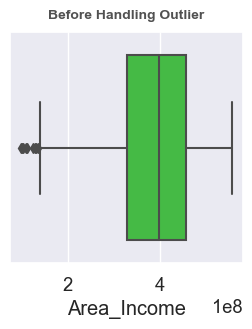

In [77]:
plt.figure(figsize=(3,3))
plt.title('Before Handling Outlier', fontsize=10, fontweight='bold', alpha=0.8, y=1.02)
sns.boxplot(x = df_prep['Area_Income'], color='limegreen')

feature area income terdapat outlier

In [78]:
# Menghitung Q1 dan Q3
Q1 = df_prep['Area_Income'].quantile(0.25)
Q3 = df_prep['Area_Income'].quantile(0.75)

# Menghitung IQR
IQR = Q3 - Q1
print('The IQR value of Area Income is: ', IQR)

# Menghitung batas atas dan bawah
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Menangani outlier
df_prep['Area_Income'] = df_prep['Area_Income'].apply(lambda x: upper_bound if x > upper_bound else x)
df_prep['Area_Income'] = df_prep['Area_Income'].apply(lambda x: lower_bound if x < lower_bound else x)

print('\nData distribution after outlier handling: ')
print(df_prep[['Area_Income']].describe())


The IQR value of Area Income is:  126873075.0

Data distribution after outlier handling: 
        Area_Income
count  1.000000e+03
mean   3.852616e+08
std    9.288397e+07
min    1.395105e+08
25%    3.298201e+08
50%    3.990683e+08
75%    4.566932e+08
max    5.563936e+08


<Axes: title={'center': 'After Handling Outlier'}, xlabel='Area_Income'>

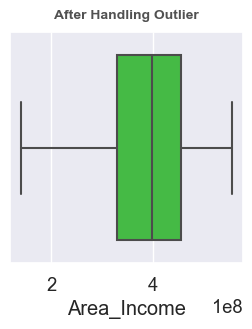

In [79]:
plt.figure(figsize=(3,3))
plt.title('After Handling Outlier', fontsize=10, fontweight='bold', alpha=0.8, y=1.02)
sns.boxplot(x = df_prep['Area_Income'], color='limegreen')

## Feature Engineering

### Feature Extraction

In [81]:
# Convert 'Timestamp' column to datetime format
df_prep['Date'] = pd.to_datetime(df_prep['Date'])
df_prep['Year'] = df_prep.Date.dt.year
df_prep['Month'] = df_prep.Date.dt.month
df_prep['Week'] =df_prep.Date.dt.dayofweek
df_prep['Day'] = df_prep.Date.dt.day

In [82]:
df_prep['Date'].head()

0   2016-03-27 00:53:00
1   2016-04-04 01:39:00
2   2016-03-13 20:35:00
3   2016-01-10 02:31:00
4   2016-06-03 03:36:00
Name: Date, dtype: datetime64[ns]

### Feature Encoding

In [83]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()
# Melakukan encoding pada fitur 'gender' dengan LabelEncoder
df_prep['Gender_encoded'] = label_encoder.fit_transform(df_prep['Gender'])

# Melakukan encoding pada fitur 'Clicked on Ad' dengan LabelEncoder
df_prep['clickedads_encoded'] = label_encoder.fit_transform(df_prep['Clicked on Ad'])

# # Inisialisasi OneHotEncoder
onehot_encoder = OneHotEncoder()
# handle dengan one hot encoding
for cat in ['city', 'province', 'category']:
  onehots = pd.get_dummies(df_prep[cat], prefix=cat)
  df_prep = df_prep.join(onehots)

### Feature Selection

In [84]:
df_prep.drop(['Unnamed: 0','Date','Clicked on Ad','city','province','category','Gender'], axis = 1, inplace=True)
df_prep.sample(5)

,Daily_Time_Spent_on_Site,Age,Area_Income,Daily_Internet_Usage,Year,Month,Week,Day,Gender_encoded,clickedads_encoded,...,category_Bank,category_Electronic,category_Fashion,category_Finance,category_Food,category_Furniture,category_Health,category_House,category_Otomotif,category_Travel
53,50.33,50,438602710.0,133.20,2016,3,2,2,0,1,...,0,0,0,0,0,0,0,1,0,0
367,77.07,40,311916010.0,261.02,2016,3,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
578,66.89,23,451037930.0,208.24,2016,1,0,4,0,0,...,0,0,0,0,0,1,0,0,0,0
405,81.58,41,388357340.0,248.16,2016,1,2,27,1,0,...,0,0,0,0,0,0,0,0,0,1
372,79.44,26,425918850.0,206.79,2016,5,6,15,1,0,...,0,0,0,0,0,0,1,0,0,0


# Modelling

In [85]:
df_model = df_prep.copy()

## Split Target & feature

In [86]:
from sklearn.model_selection import train_test_split
X = df_model.drop(labels=['clickedads_encoded'],axis=1)
y = df_model[['clickedads_encoded']]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify=y,random_state = 42)
print('Train:',X_train.shape)
print('Test:',X_test.shape)

Train: (700, 65)
Test: (300, 65)


In [87]:
from sklearn.metrics import f1_score

def modelling(X_train, X_test, y_train, y_test):
    result = defaultdict(list)

    KNN = KNeighborsClassifier()
    XGB = XGBClassifier()
    RF = RandomForestClassifier()
    GDB = GradientBoostingClassifier()
    LGBM = lgb.LGBMClassifier(force_col_wise=True)

    list_model = [('K-Nearest Neighbor', KNN),
                  ('XgBoost', XGB),
                  ('Random Forest', RF),
                  ('Gradient Boosting', GDB),
                  ('LightGBM', LGBM)
                  ]

    for model_name, model in list_model:
        start = dt.now()
        model.fit(X_train, y_train)
        duration = (dt.now() - start).total_seconds()

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        result['model_name'].append(model_name)
        result['model'].append(model)
        result['accuracy'].append(accuracy)
        result['recall'].append(recall)
        result['precision'].append(precision)
        result['f1_score'].append(f1)
        result['duration'].append(duration)

    return result

### Modelling 1 (Without Normalization)

In [88]:
eval_modelling = modelling(X_train, X_test, y_train, y_test)
eval_modelling = pd.DataFrame(eval_modelling)
eval_modelling

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 350, number of negative: 350
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,model_name,model,accuracy,recall,precision,f1_score,duration
0,K-Nearest Neighbor,KNeighborsClassifier(),0.673333,0.640000,0.685714,0.662069,0.009973
1,XgBoost,"XGBClassifier(base_score=None, booster=None, c...",0.963333,0.966667,0.960265,0.963455,0.345587
2,Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.963333,0.973333,0.954248,0.963696,0.631311
3,Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.960000,0.960000,0.960000,0.960000,1.185767
4,LightGBM,LGBMClassifier(force_col_wise=True),0.973333,0.966667,0.979730,0.973154,0.175537


### Modelling 2 (With Normalization)

In [89]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

In [90]:
eval_modelling2 = modelling(X_train_minmax, X_test_minmax, y_train, y_test)
eval_modelling2 = pd.DataFrame(eval_modelling2)
eval_modelling2

[LightGBM] [Info] Number of positive: 350, number of negative: 350
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

,model_name,model,accuracy,recall,precision,f1_score,duration
0,K-Nearest Neighbor,KNeighborsClassifier(),0.723333,0.686667,0.741007,0.712803,0.004988
1,XgBoost,"XGBClassifier(base_score=None, booster=None, c...",0.963333,0.966667,0.960265,0.963455,0.148604
2,Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.966667,0.966667,0.966667,0.966667,0.524598
3,Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.960000,0.960000,0.960000,0.960000,1.036226
4,LightGBM,LGBMClassifier(force_col_wise=True),0.970000,0.966667,0.973154,0.969900,0.168556


### Confusion Matrix

In [91]:
lgm = lgb.LGBMClassifier()
lgm.fit(X_train, y_train)
y_pred_lgm = lgm.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 350, number of negative: 350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [92]:
def confusion_matrix_visual(ytest, pred):
    # Creating confusion matrix 
    cm = confusion_matrix(ytest, pred)

    # Putting the matrix a dataframe form  
    df_cm = pd.DataFrame(cm, index=['Click ad', 'Not Click ad'],
                 columns=['Click ad', 'Not Click ad'])
    
    # visualizing the confusion matrix
    sns.set(font_scale=1.2)
    plt.figure(figsize=(9,5))
        
    sns.heatmap(df_cm, annot=True, fmt='g', cmap="Purples",xticklabels=df_cm.columns, yticklabels=df_cm.index, annot_kws={"size": 10})
    plt.title("Plot Confusion Matrix", size=20)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


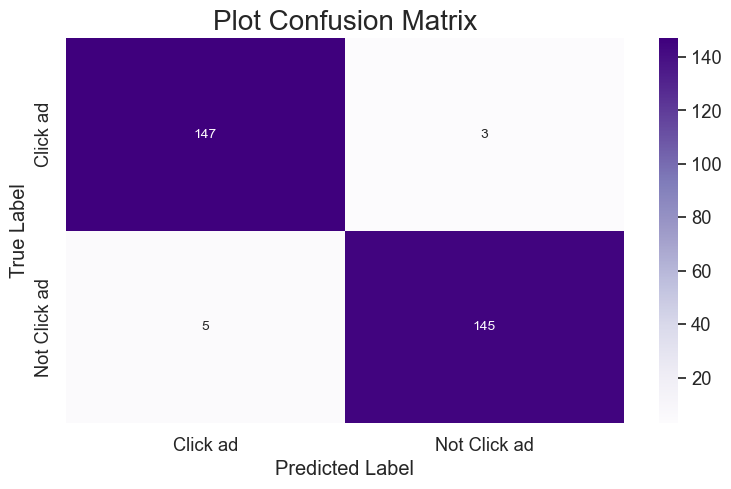

In [93]:
confusion_matrix_visual(y_test, y_pred_lgm)

True Positive (TP), Jumlah TP adalah 147
False Negative (FN), Jumlah FN adalah 3
False Positive (FP), Jumlah FP adalah 5
True Negative (TN). Jumlah TN adalah 145.

# Feature Importance

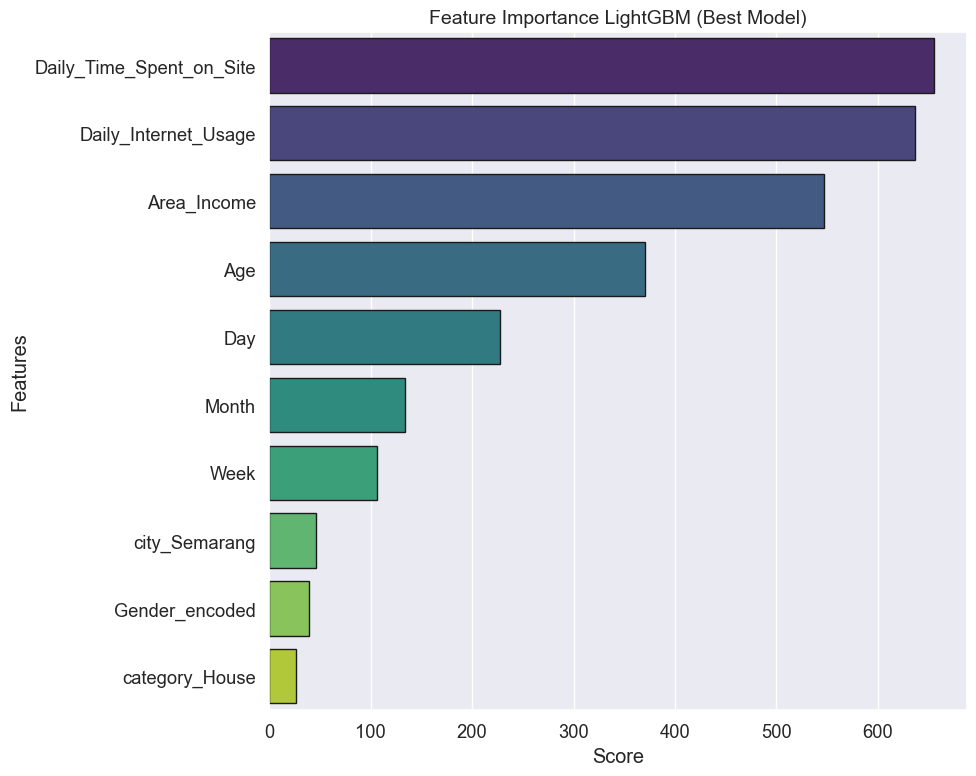

In [94]:
feat_importances_lgbm = pd.Series(lgm.feature_importances_, index=X.columns)
df_feature = feat_importances_lgbm.nlargest(10).sort_values(ascending=False).to_frame(name='Score').reset_index()

plt.figure(figsize=(10,8))
sns.barplot(data=df_feature, y='index', x='Score', palette='viridis', edgecolor='.1')
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Feature Importance LightGBM (Best Model)', fontsize=14)
plt.tight_layout()
plt.show()

In [95]:
df_feature

,index,Score
0,Daily_Time_Spent_on_Site,655
1,Daily_Internet_Usage,637
2,Area_Income,547
3,Age,370
4,Day,228
5,Month,134
6,Week,106
7,city_Semarang,46
8,Gender_encoded,39
9,category_House,26
